<a href="https://colab.research.google.com/github/LeMagnifiq/CustomerSegmentation-Analysis/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Dataset

In [2]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
df = pd.read_excel(url)

## Data Cleaning and Preparation

In [3]:
#Check for missing value
print(df.isnull().sum())


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [4]:
# Fill missing descriptions with 'Unknown'
df['Description'].fillna('Unknown', inplace=True)

# Drop rows with missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

# Confirming all missing values are handled
print(df.isnull().sum())


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [5]:
print("Number of duplicates: ", df.duplicated().sum())

# Drop duplicates
df = df.drop_duplicates()

print("Number of duplicates after removal: ", df.duplicated().sum())


Number of duplicates:  5225
Number of duplicates after removal:  0


In [6]:
#Quantity less than zero)
df = df[df['Quantity']>0]

## Exploratory Data Analysis (EDA)

In [7]:
# Show the top 5 rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,392732.000000,392732.000000,392732.000000
mean,13.153718,3.125596,15287.734822
std,181.588420,22.240725,1713.567773
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


### Data Distribution

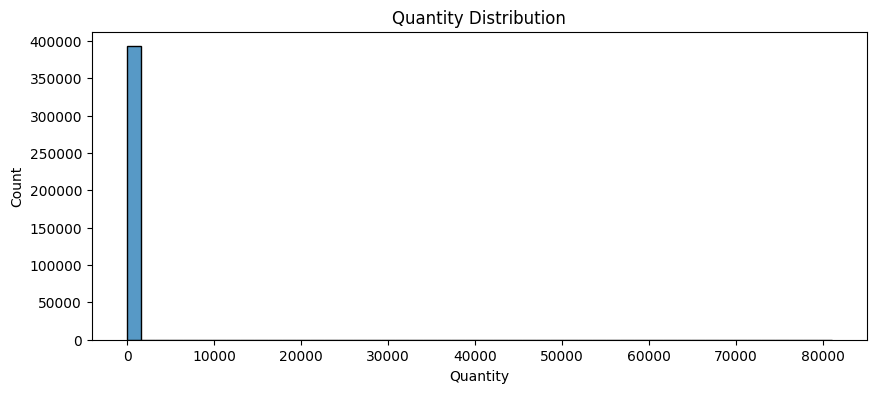

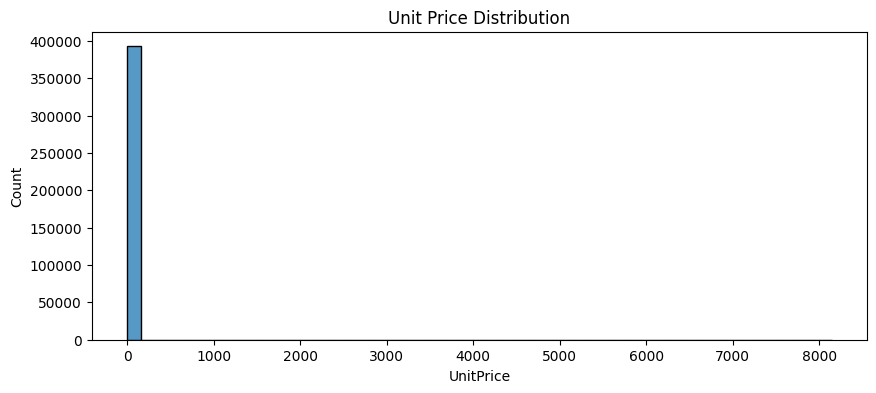

In [9]:
# For Quantity
plt.figure(figsize=(10,4))
sns.histplot(df['Quantity'], bins=50, kde=False)
plt.title('Quantity Distribution')
plt.show()

# For UnitPrice
plt.figure(figsize=(10,4))
sns.histplot(df['UnitPrice'], bins=50, kde=False)
plt.title('Unit Price Distribution')
plt.show()

In [10]:
# For Quantity
Q1 = df['Quantity'].quantile(0.25)
Q3 = df['Quantity'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_quantity = df[(df['Quantity'] < lower_bound) | (df['Quantity'] > upper_bound)]['Quantity'].count()

# For UnitPrice
Q1 = df['UnitPrice'].quantile(0.25)
Q3 = df['UnitPrice'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_unitprice = df[(df['UnitPrice'] < lower_bound) | (df['UnitPrice'] > upper_bound)]['UnitPrice'].count()

print("Quantity outliers: ", outliers_quantity)
print("UnitPrice outliers: ", outliers_unitprice)


Quantity outliers:  25625
UnitPrice outliers:  34112


In [11]:
correlation = df[['Quantity', 'UnitPrice']].corr()
print(correlation)


           Quantity  UnitPrice
Quantity   1.000000  -0.004577
UnitPrice -0.004577   1.000000


In [12]:
# Extract month-year from InvoiceDate
df['InvoiceMonthYear'] = df['InvoiceDate'].dt.to_period('M')

# Quantity over time
quantity_over_time = df.groupby('InvoiceMonthYear')['Quantity'].sum()
print(quantity_over_time.describe())

# UnitPrice over time
unitprice_over_time = df.groupby('InvoiceMonthYear')['UnitPrice'].mean()
print(unitprice_over_time.describe())


count        13.000000
mean     397375.846154
std      127230.162251
min      265043.000000
25%      311063.000000
50%      363014.000000
75%      398190.000000
max      678760.000000
Name: Quantity, dtype: float64
count    13.000000
mean      3.134421
std       0.259532
min       2.734624
25%       2.943614
50%       3.142586
75%       3.269753
max       3.615349
Name: UnitPrice, dtype: float64


## Key Insights

Popular Products

In [13]:
popular_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False)
print(popular_products.head(10))

Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54319
JUMBO BAG RED RETROSPOT               46078
WHITE HANGING HEART T-LIGHT HOLDER    36706
ASSORTED COLOUR BIRD ORNAMENT         35263
PACK OF 72 RETROSPOT CAKE CASES       33670
POPCORN HOLDER                        30919
RABBIT NIGHT LIGHT                    27153
MINI PAINT SET VINTAGE                26076
Name: Quantity, dtype: int64


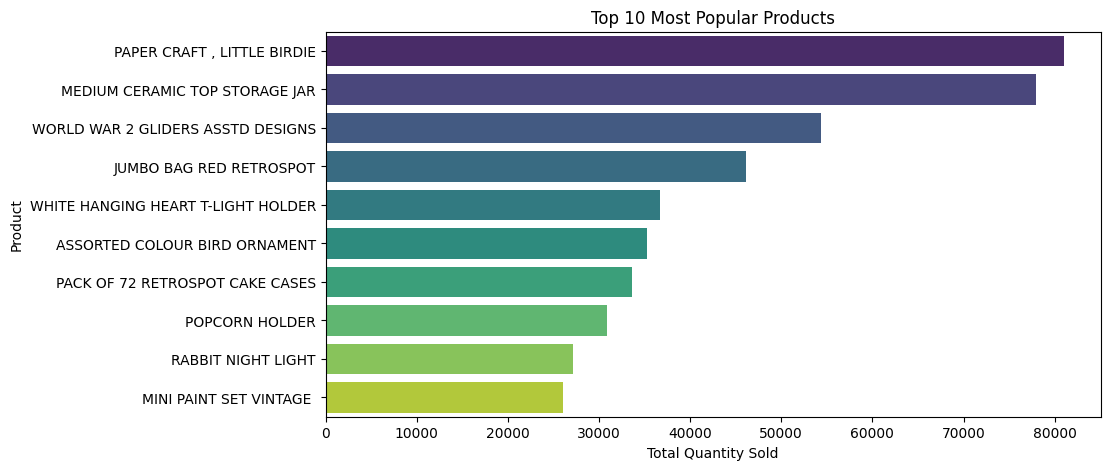

In [14]:
# Select the top 10
top_10_products = popular_products[:10]

# Plot
plt.figure(figsize=(10,5))
sns.barplot(y=top_10_products.index, x=top_10_products.values, palette='viridis')
plt.title('Top 10 Most Popular Products')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product')
plt.show()


Most Valuable Customers

In [15]:
df['TotalSpent'] = df['UnitPrice'] * df['Quantity']
top_customers = df.groupby('CustomerID')['TotalSpent'].sum().sort_values(ascending=False)
print(top_customers.head(10))


CustomerID
14646.0    280206.02
18102.0    259657.30
17450.0    194390.79
16446.0    168472.50
14911.0    143711.17
12415.0    124914.53
14156.0    117210.08
17511.0     91062.38
16029.0     80850.84
12346.0     77183.60
Name: TotalSpent, dtype: float64


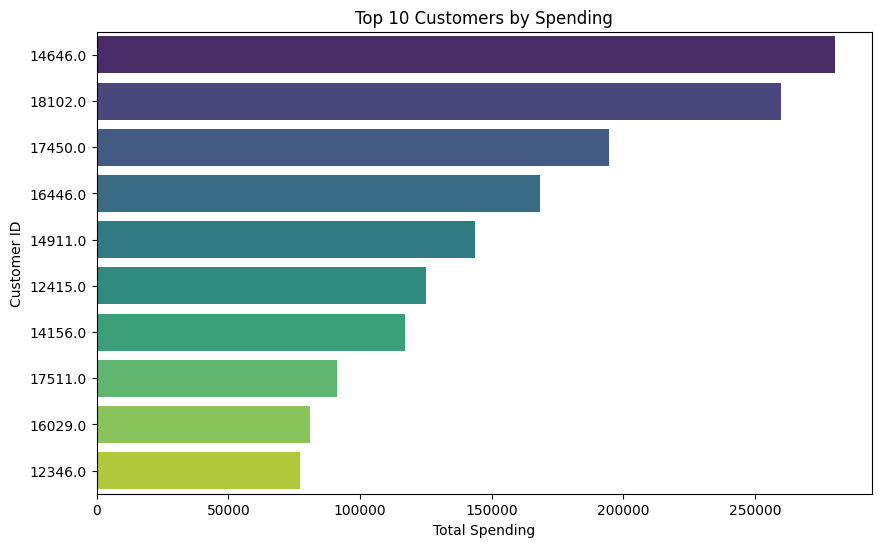

In [16]:
#Reset index and
top_10_customers = top_customers.reset_index()[:10]

#Select the top 10
top_10_customers = top_customers.reset_index()[:10]

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=top_10_customers['TotalSpent'], y=top_10_customers['CustomerID'].astype(str), palette='viridis')
plt.title('Top 10 Customers by Spending')
plt.xlabel('Total Spending')
plt.ylabel('Customer ID')
plt.show()

Order Patterns Over Time



<Axes: title={'center': 'Number of Orders Over Time'}, xlabel='Month'>

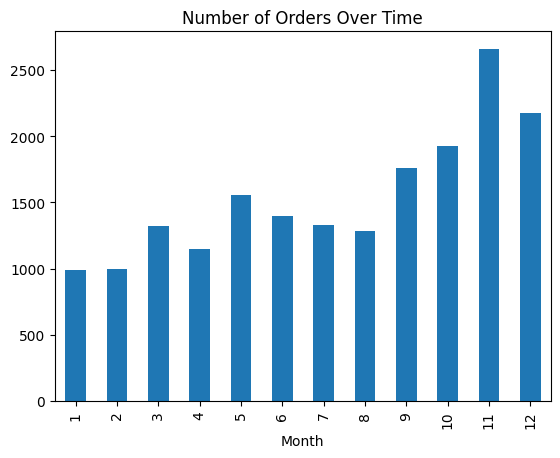

In [17]:
df['Month'] = df['InvoiceDate'].dt.month
monthly_orders = df.groupby('Month')['InvoiceNo'].nunique()
monthly_orders.plot(kind='bar', title='Number of Orders Over Time')

Customer Geographic Distribution

<Axes: title={'center': 'Number of Customers by Country'}, xlabel='Country'>

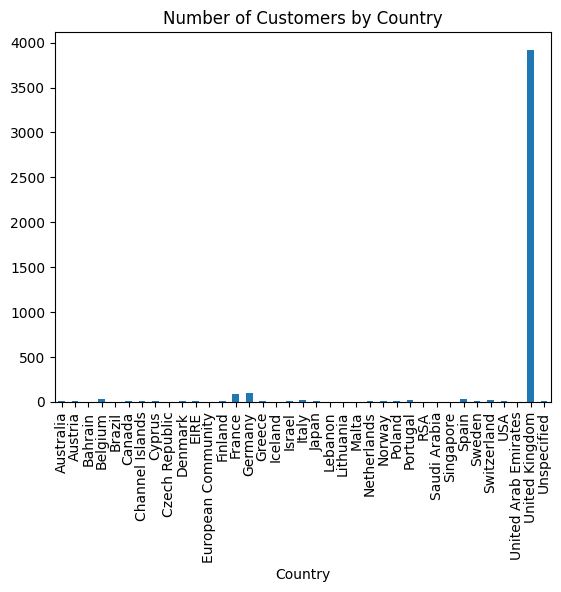

In [18]:
customer_countries = df.groupby('Country')['CustomerID'].nunique()
customer_countries.plot(kind='bar', title='Number of Customers by Country')

Spending Patterns

<Axes: title={'center': 'Revenue Over Time'}, xlabel='Month'>

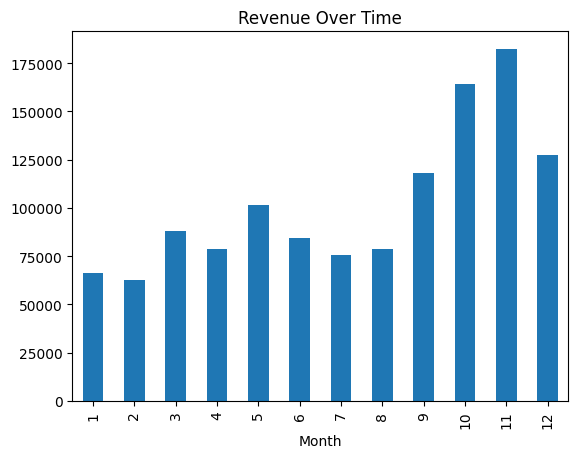

In [19]:
monthly_revenue = df.groupby('Month')['UnitPrice'].sum()
monthly_revenue.plot(kind='bar', title='Revenue Over Time')

Purchase Patterns

In [20]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Prepare the data
basket = (df[df['Country'] =="United Kingdom"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

# Convert the units to 1 hot encoded values
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

# Compute frequent items using the Apriori algorithm
frequent_itemsets = apriori(basket_sets, min_support=0.02, use_colnames=True)

# Compute all association rules for frequent_itemsets
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Print rules
print(rules)

                                          antecedents  \
0                        (ALARM CLOCK BAKELIKE GREEN)   
1                         (ALARM CLOCK BAKELIKE RED )   
2                 (GARDENERS KNEELING PAD KEEP CALM )   
3                (GARDENERS KNEELING PAD CUP OF TEA )   
4                    (PINK REGENCY TEACUP AND SAUCER)   
..                                                ...   
71  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...   
72  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...   
73                   (PINK REGENCY TEACUP AND SAUCER)   
74                  (GREEN REGENCY TEACUP AND SAUCER)   
75                 (ROSES REGENCY TEACUP AND SAUCER )   

                                          consequents  antecedent support  \
0                         (ALARM CLOCK BAKELIKE RED )            0.041444   
1                        (ALARM CLOCK BAKELIKE GREEN)            0.045528   
2                (GARDENERS KNEELING PAD CUP OF TEA )            0.044567   
3      

## Customer Segmentation

### Feature Engineering

In [21]:
import datetime as dt

snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1) #latest date in the data plus one day
df_RFM = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, #Recency
    'InvoiceNo': 'nunique', #Frequency
    'TotalSpent': 'sum' #MonetaryValue
})

# Rename columns for easier interpretation
df_RFM.rename(columns = {
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSpent': 'MonetaryValue'
}, inplace=True)

# Print top 5 rows
print(df_RFM.head())



            Recency  Frequency  MonetaryValue
CustomerID                                   
12346.0         326          1       77183.60
12347.0           2          7        4310.00
12348.0          75          4        1797.24
12349.0          19          1        1757.55
12350.0         310          1         334.40


## Feature Scaling

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(df_RFM)
rfm_scaled = pd.DataFrame(rfm_scaled, index=df_RFM.index, columns=df_RFM.columns)


## K-Means Clustering

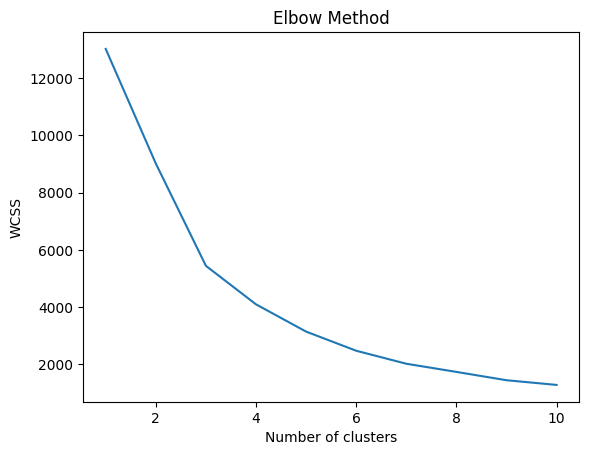

In [23]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [24]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(rfm_scaled)

# Assigning the clusters to our original pre-scaled dataframe
df_RFM['Cluster'] = clusters


## Cluster Analysis

In [25]:
cluster_analysis = df_RFM.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']}).round(0)

print(cluster_analysis)


        Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          93.0       4.0        1543.0  4313
1           6.0      66.0       85826.0    26


Cluster 0: The customers in this cluster have an average recency of 93 days, which means they haven't purchased for about 3 months on average. They purchase about 4 times on average and have an average monetary value of 1543. This is the largest cluster with 4313 customers.

Cluster 1: The customers in this cluster have a very low average recency of 6 days, indicating that they have purchased very recently. They purchase very frequently (66 times on average) and spend a high amount on average (85826). This cluster, however, is much smaller with only 26 customers.

## Model Selection and Training

Random Forests

In [26]:
from sklearn.model_selection import train_test_split

# Prepare the features (X) and the target (y)
X = df_RFM.drop('Cluster', axis=1)
y = df_RFM['Cluster']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [28]:
from sklearn.metrics import classification_report

# Predict the clusters on the test set
y_pred = rf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       864
           1       1.00      1.00      1.00         4

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868



In [29]:
from sklearn.model_selection import cross_val_score

# Defining your features and target
X = rfm_scaled
y = df_RFM['Cluster']

# Creating the Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)

# Cross-validating with 5 folds
scores = cross_val_score(rf_clf, X, y, cv=5)

# Printing the cross-validation scores and the mean of them
print('Cross-Validation Accuracy Scores:', scores)
print('Average Cross-Validation Accuracy:', scores.mean())


Cross-Validation Accuracy Scores: [1.         0.99884793 0.99884793 0.99769585 1.        ]
Average Cross-Validation Accuracy: 0.9990783410138249


In [30]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("ROC-AUC Score: ", roc_auc)
print("Confusion Matrix: \n", cm)


Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
ROC-AUC Score:  1.0
Confusion Matrix: 
 [[864   0]
 [  0   4]]


Gradient Boosting

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Create a GradientBoostingClassifier object
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42)

# Fit the model to your data
gb.fit(X_train, y_train)

# Predict the classes of the test set
y_pred = gb.predict(X_test)

# Print accuracy
print('Accuracy: ', accuracy_score(y_test, y_pred))

# Print precision
print('Precision: ', precision_score(y_test, y_pred))

# Print recall
print('Recall: ', recall_score(y_test, y_pred))

# Print F1 Score
print('F1 Score: ', f1_score(y_test, y_pred))

# Print ROC-AUC Score
print('ROC-AUC Score: ', roc_auc_score(y_test, y_pred))

# Print confusion matrix
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))


Accuracy:  0.9976958525345622
Precision:  0.75
Recall:  0.75
F1 Score:  0.75
ROC-AUC Score:  0.8744212962962963
Confusion Matrix: 
 [[863   1]
 [  1   3]]


## More Feature Engineering

In [32]:
#New Feature
bins = [0, 30, 90, np.inf]
labels = ['Active', 'Lapsed', 'Inactive']
df_RFM['Recency_Binned'] = pd.cut(df_RFM['Recency'], bins, labels=labels)

In [33]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_RFM['Recency_Binned_Encoded'] = le.fit_transform(df_RFM['Recency_Binned'])


In [34]:
# Binning Frequency
bins = [0, 5, 20, np.inf]
labels = ['Rare', 'Occasional', 'Regular']
df_RFM['Frequency_Binned'] = pd.cut(df_RFM['Frequency'], bins, labels=labels)

# Binning MonetaryValue
bins = [0, 1000, 5000, np.inf]
labels = ['Low-spending', 'Medium-spending', 'High-spending']
df_RFM['MonetaryValue_Binned'] = pd.cut(df_RFM['MonetaryValue'], bins, labels=labels)


In [35]:
le = LabelEncoder()
df_RFM['Frequency_Binned_Encoded'] = le.fit_transform(df_RFM['Frequency_Binned'])
df_RFM['MonetaryValue_Binned_Encoded'] = le.fit_transform(df_RFM['MonetaryValue_Binned'])


In [36]:
print(df_RFM)

            Recency  Frequency  MonetaryValue  Cluster Recency_Binned  \
CustomerID                                                              
12346.0         326          1       77183.60        0       Inactive   
12347.0           2          7        4310.00        0         Active   
12348.0          75          4        1797.24        0         Lapsed   
12349.0          19          1        1757.55        0         Active   
12350.0         310          1         334.40        0       Inactive   
...             ...        ...            ...      ...            ...   
18280.0         278          1         180.60        0       Inactive   
18281.0         181          1          80.82        0       Inactive   
18282.0           8          2         178.05        0         Active   
18283.0           4         16        2045.53        0         Active   
18287.0          43          3        1837.28        0         Lapsed   

            Recency_Binned_Encoded Frequency_Binne

In [37]:
# Convert categorical variable into dummy/indicator variables or (binary variables)
final_data = pd.get_dummies(df_RFM, drop_first=True)

#Split
X_train, X_test, y_train, y_test = train_test_split(final_data, y, test_size=0.2, random_state=0)


In [38]:
from sklearn.ensemble import GradientBoostingClassifier


# Fit the model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
gb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = gb_model.predict(X_test)

# Evaluate the model
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))


Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0


SVM

In [39]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

# Initialize SVM classifier
clf = svm.SVC(kernel='linear')

# Fit data
clf = clf.fit(X_train, y_train)

# Predict the response
pred = clf.predict(X_test)

# Print classification report
print(classification_report(y_test, pred))

# Print confusion matrix
print(confusion_matrix(y_test, pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       860
           1       1.00      1.00      1.00         8

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868

[[860   0]
 [  0   8]]


In [40]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Features matrix
X = df_RFM[['Recency_Binned_Encoded', 'Frequency_Binned_Encoded', 'MonetaryValue_Binned_Encoded']]

# Target vector
y = df_RFM['Cluster']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply cross-validation
svc = SVC(kernel='linear', C=1, random_state=42)
strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(svc, X_train, y_train, cv=strat_k_fold, scoring='accuracy')




In [41]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

# Performance metrics
metrics = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, average='weighted', zero_division=0),
           'recall': make_scorer(recall_score, average='weighted', zero_division=0),
           'f1': make_scorer(f1_score, average='weighted', zero_division=0)}

scores = {}

# Applying cross-validation
for metric_name, metric in metrics.items():
    score = cross_val_score(svc, X, y, cv=strat_k_fold, scoring=metric).mean()
    scores[metric_name] = score

for metric, score in scores.items():
    print(f"The {metric} score is {score}")

The accuracy score is 0.9940078877850951
The precision score is 0.9880518927375184
The recall score is 0.9940078877850951
The f1 score is 0.9910208884411418


Random Forests

In [42]:
from sklearn.ensemble import RandomForestClassifier

# Assuming df and X, y are defined above and are correct

# Create model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Apply cross-validation
strat_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for train_index, test_index in strat_k_fold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on training data
    rf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = rf.predict(X_test)

    # Calculate metrics and append them to the lists
    accuracy_list.append(accuracy_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred, average='weighted', zero_division=1))
    recall_list.append(recall_score(y_test, y_pred, average='weighted'))
    f1_list.append(f1_score(y_test, y_pred, average='weighted'))

# Print out the average scores
print(f'The accuracy score is {np.mean(accuracy_list)}')
print(f'The precision score is {np.mean(precision_list)}')
print(f'The recall score is {np.mean(recall_list)}')
print(f'The f1 score is {np.mean(f1_list)}')


The accuracy score is 0.9940078877850951
The precision score is 0.9940440049524233
The recall score is 0.9940078877850951
The f1 score is 0.9910208884411418
